<a href="https://colab.research.google.com/github/ritwikraha/Open-Generative-Fill/blob/main/experiments/owlv2-with-sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from transformers import (
    Owlv2ForObjectDetection,
    Owlv2Processor,
    SamModel,
    SamProcessor,
)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
image_url = "https://i.imgur.com/qrN1OzK.jpeg"
raw_image = Image.open(
    requests.get(image_url, stream=True).raw
).convert("RGB")

image = raw_image.resize((512, 512))
edit_prompt = "replace the bridge with bricks"

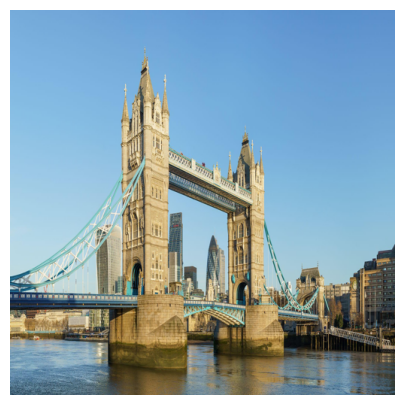

In [15]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

In [16]:
def delete_model(model):
    model.to("cpu")
    del model
    torch.cuda.empty_cache()

In [17]:
object_to_segment = "bridge"

In [18]:
# OWL-V2 for object detection
owl_v2_model_id = "google/owlv2-base-patch16-ensemble"
processor = Owlv2Processor.from_pretrained(owl_v2_model_id)
od_model = Owlv2ForObjectDetection.from_pretrained(owl_v2_model_id).to(device)
text_queries = [object_to_segment]
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = od_model(**inputs)
    target_sizes = torch.tensor([image.size]).to(device)
    results = processor.post_process_object_detection(
        outputs, threshold=0.1, target_sizes=target_sizes
    )[0]

boxes = results["boxes"].tolist()

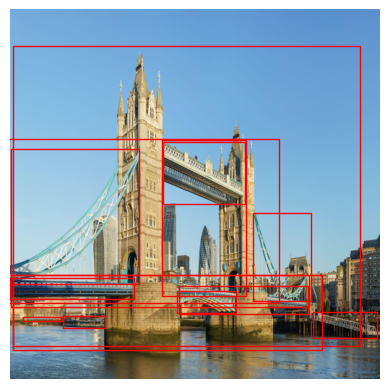

In [23]:
fig, ax = plt.subplots()
ax.imshow(image)

for box in boxes:
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax.add_patch(rect)

plt.axis("off")
plt.show()

In [24]:
delete_model(od_model)

In [25]:
# SAM for image segmentation
sam_model_id = "facebook/sam-vit-base"
seg_model = SamModel.from_pretrained(sam_model_id).to(device)
processor = SamProcessor.from_pretrained(sam_model_id)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [65]:
input_boxes = [boxes]
inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = seg_model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu(),
)[0]

In [66]:
masks = torch.max(masks[:, 0, ...], dim=0, keepdim=False).values
masks.shape

torch.Size([512, 512])

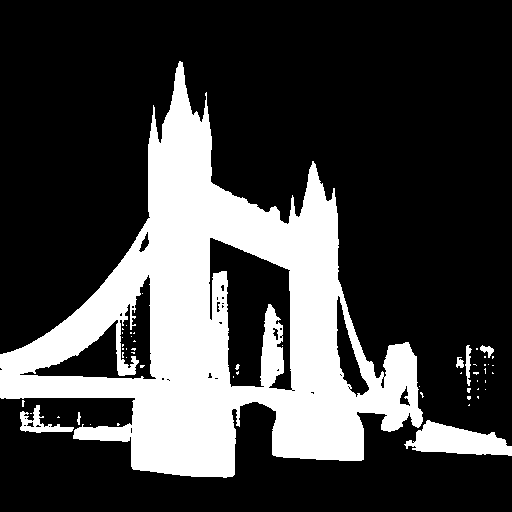

In [67]:
Image.fromarray(masks.numpy())